# VGG

This notebook uses model "VGG16" to conduct regression of images.

In [ ]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

## Step 1 - Config

First set the hyperparameters and other configurations.

In [ ]:
# Dataset and model path
DATASET_PATH = "./datasets/Ra_128_indexed.h5"
MODEL_DIR = "./models"
OUTPUT_DIR = "./outputs"
# Env
SEED = 42
# Dataset
MIN_LABEL = 1.3
MAX_LABEL = 5.2
# Hyperparameters
FINE_TUNING_TYPE = "full" # "partial" or "full"
NUM_EPOCHS = 300
LR = 1e-3
LR_WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.2
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_VAL = 10

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Path
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR, exist_ok=True)
    print(f"Make new directory {MODEL_DIR}")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Make new directory {OUTPUT_DIR}")
MODEL_PATH = f"{MODEL_DIR}/VGG16_{FINE_TUNING_TYPE}_test_size_{TEST_SIZE}_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.pth"
OUTPUT_PATH = f"{OUTPUT_DIR}/VGG16_{FINE_TUNING_TYPE}_test_size_{TEST_SIZE}_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.csv"

Device: cuda


Then load the pretrained model from `torchvision`.

In [ ]:
# Pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Change the last layer to fit the regression task
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=1)

# Choose to freeze the layers or not
if FINE_TUNING_TYPE == "partial":
    for param in vgg16.features.parameters():
        param.requires_grad = False

# Move to the appropriate device
vgg16 = vgg16.to(device)

/home/ubuntu/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 2 - Load data

In this step we load the images and process them, the goal is to get `train_loader` and `val_loader` for training. After this step we will get:

1. `images_train` and `images_val` (4 dim tensor)
2. `labels_train` and `labels_val` (1 dim tensor)
3. `train_dataset` and `val_dataset` (dataset)
4. `train_loader` and `val_loader` (dataloader)

First we load the images (`images`) and labels (`labels`).

In [ ]:
# Load datasets
with h5py.File(DATASET_PATH, "r") as f:
    images = f["images"][:].astype(float)
    labels = f["labels"][:].astype(float)
N_all = len(images)
print("Images and labels loaded.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Selection
indx = np.where((labels >= MIN_LABEL) * (labels < MAX_LABEL) == True)[0]
labels = labels[indx]
images = images[indx]
print(f"Select indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# To tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2)
labels = torch.from_numpy(labels)
print("Transform `images` and `labels` to tensors.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")

Images and labels loaded.
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)



Select indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)

Transform `images` and `labels` to tensors.
Images Shape: torch.Size([9192, 3, 128, 128])
Labels Shape: torch.Size([9192])


Then use `train_test_split` function to get data for training and validation.

In [ ]:
# Train-test split
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=SEED
)

Implement images standardization and labels normalization.

In [ ]:
# Image standardization
mean = images_train.mean(dim=[0, 2, 3], keepdim=True)
std = images_train.std(dim=[0, 2, 3], keepdim=True)
print(f"Mean of `images_train`: {mean}")
print(f"Std of `images_train`: {std}")
images_train = (images_train - mean) / std
images_val = (images_val - mean) / std

# Label normalization
labels_train = (labels_train - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)
labels_val = (labels_val - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)

print(f"Train test split with test size {TEST_SIZE}.")
print(f"Images (train) Shape: {images_train.shape}")
print(f"Images (val) Shape: {images_val.shape}")
print(f"Labels (train) Shape: {labels_train.shape}")
print(f"Labels (val) Shape: {labels_val.shape}")

Mean of `images_train`: tensor([[[[ 13.5371]],

         [[ 17.8462]],

         [[112.1119]]]], dtype=torch.float64)
Std of `images_train`: tensor([[[[18.5847]],

         [[20.2589]],

         [[41.6000]]]], dtype=torch.float64)


Train test split with test size 0.2.
Images (train) Shape: torch.Size([7353, 3, 128, 128])
Images (val) Shape: torch.Size([1839, 3, 128, 128])
Labels (train) Shape: torch.Size([7353])
Labels (val) Shape: torch.Size([1839])


Next, we should transform the data to tensors, combine `images` and `labels` to datasets and get dataloaders according to `BATCH_SIZE`.

In [ ]:
# Change to tensor
images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)
print(f"Shape of `images_train_tensor`: {images_train_tensor.shape}")
print(f"Shape of `labels_train_tensor`: {labels_train_tensor.shape}")
print(f"Shape of `images_val_tensor`: {images_val_tensor.shape}")
print(f"Shape of `labels_val_tensor`: {labels_val_tensor.shape}")

# Tensor's dataset
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
val_dataset = TensorDataset(images_val_tensor, labels_val_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL)

/tmp/ipykernel_5641/1722485521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_train_tensor = torch.tensor(images_train, dtype=torch.float32)


Shape of `images_train_tensor`: torch.Size([7353, 3, 128, 128])
Shape of `labels_train_tensor`: torch.Size([7353, 1])
Shape of `images_val_tensor`: torch.Size([1839, 3, 128, 128])
Shape of `labels_val_tensor`: torch.Size([1839, 1])


/tmp/ipykernel_5641/1722485521.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
/tmp/ipykernel_5641/1722485521.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_5641/1722485521.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)


## Step 3 - Train

Start training for `epoch` loops, record the training losses and validation losses.

In [ ]:
# Criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    vgg16.classifier.parameters(), lr=LR, weight_decay=LR_WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# Record the loss values
train_loss_list = []
val_loss_list = []

# Loop by epoch
for epoch in range(NUM_EPOCHS):

    # Train
    vgg16.train()
    train_loss = 0.0
    train_size = 0
    for batch_images, batch_labels in train_loader:
        # Load data
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # Pass loss value
        outputs = vgg16(batch_images)
        loss = criterion(outputs, batch_labels)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add to the total loss
        batch_size = batch_images.size(0)
        train_loss += loss.item() * batch_size
        train_size += batch_size

    train_loss = train_loss / train_size
    train_loss_list.append(train_loss)

    # Validate
    vgg16.eval()
    val_loss = 0
    val_samples = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            # Load data
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            # Output
            outputs = vgg16(batch_images)
            # Calculate loss
            loss = criterion(outputs, batch_labels)
            # Add to total loss
            batch_size = batch_images.size(0)
            val_loss += loss.item() * batch_size
            val_samples += batch_size
    val_loss /= val_samples
    val_loss_list.append(val_loss)

    # Print
    print(
        f"[Epoch {(epoch+1):d} / {(NUM_EPOCHS):d}] [Train Loss {train_loss:f} (MSE)] [Valid Loss {val_loss:f} (MSE)] [Learning Rate: {optimizer.param_groups[0]['lr']}]"
    )

    # Scheduler
    scheduler.step(val_loss)

[Epoch 1 / 200] [Train Loss 4.764985 (MSE)] [Valid Loss 0.060993 (MSE)] [Learning Rate: 0.001]


[Epoch 2 / 200] [Train Loss 0.066880 (MSE)] [Valid Loss 0.044315 (MSE)] [Learning Rate: 0.001]


[Epoch 3 / 200] [Train Loss 0.054243 (MSE)] [Valid Loss 0.037586 (MSE)] [Learning Rate: 0.001]


[Epoch 4 / 200] [Train Loss 0.053007 (MSE)] [Valid Loss 0.021087 (MSE)] [Learning Rate: 0.001]


[Epoch 5 / 200] [Train Loss 0.048122 (MSE)] [Valid Loss 0.020654 (MSE)] [Learning Rate: 0.001]


[Epoch 6 / 200] [Train Loss 0.041750 (MSE)] [Valid Loss 0.047291 (MSE)] [Learning Rate: 0.001]


[Epoch 7 / 200] [Train Loss 0.045241 (MSE)] [Valid Loss 0.015438 (MSE)] [Learning Rate: 0.001]


[Epoch 8 / 200] [Train Loss 0.038683 (MSE)] [Valid Loss 0.013701 (MSE)] [Learning Rate: 0.001]


[Epoch 9 / 200] [Train Loss 0.037355 (MSE)] [Valid Loss 0.015310 (MSE)] [Learning Rate: 0.001]


[Epoch 10 / 200] [Train Loss 0.038772 (MSE)] [Valid Loss 0.056177 (MSE)] [Learning Rate: 0.001]


[Epoch 11 / 200] [Train Loss 0.043890 (MSE)] [Valid Loss 0.036135 (MSE)] [Learning Rate: 0.001]


[Epoch 12 / 200] [Train Loss 0.052595 (MSE)] [Valid Loss 0.104893 (MSE)] [Learning Rate: 0.001]


[Epoch 13 / 200] [Train Loss 0.042273 (MSE)] [Valid Loss 0.023799 (MSE)] [Learning Rate: 0.001]


[Epoch 14 / 200] [Train Loss 0.031324 (MSE)] [Valid Loss 0.028986 (MSE)] [Learning Rate: 0.001]


[Epoch 15 / 200] [Train Loss 0.027373 (MSE)] [Valid Loss 0.012213 (MSE)] [Learning Rate: 0.0005]


[Epoch 16 / 200] [Train Loss 0.030039 (MSE)] [Valid Loss 0.010635 (MSE)] [Learning Rate: 0.0005]


[Epoch 17 / 200] [Train Loss 0.027977 (MSE)] [Valid Loss 0.010062 (MSE)] [Learning Rate: 0.0005]


[Epoch 18 / 200] [Train Loss 0.024119 (MSE)] [Valid Loss 0.009581 (MSE)] [Learning Rate: 0.0005]


[Epoch 19 / 200] [Train Loss 0.024079 (MSE)] [Valid Loss 0.009900 (MSE)] [Learning Rate: 0.0005]


[Epoch 20 / 200] [Train Loss 0.023756 (MSE)] [Valid Loss 0.008470 (MSE)] [Learning Rate: 0.0005]


[Epoch 21 / 200] [Train Loss 0.024110 (MSE)] [Valid Loss 0.010824 (MSE)] [Learning Rate: 0.0005]


[Epoch 22 / 200] [Train Loss 0.025217 (MSE)] [Valid Loss 0.012078 (MSE)] [Learning Rate: 0.0005]


[Epoch 23 / 200] [Train Loss 0.026262 (MSE)] [Valid Loss 0.008903 (MSE)] [Learning Rate: 0.0005]


[Epoch 24 / 200] [Train Loss 0.025364 (MSE)] [Valid Loss 0.008032 (MSE)] [Learning Rate: 0.0005]


[Epoch 25 / 200] [Train Loss 0.023443 (MSE)] [Valid Loss 0.010797 (MSE)] [Learning Rate: 0.0005]


[Epoch 26 / 200] [Train Loss 0.021732 (MSE)] [Valid Loss 0.009252 (MSE)] [Learning Rate: 0.0005]


[Epoch 27 / 200] [Train Loss 0.023749 (MSE)] [Valid Loss 0.009196 (MSE)] [Learning Rate: 0.0005]


[Epoch 28 / 200] [Train Loss 0.028431 (MSE)] [Valid Loss 0.009096 (MSE)] [Learning Rate: 0.0005]


[Epoch 29 / 200] [Train Loss 0.023773 (MSE)] [Valid Loss 0.014412 (MSE)] [Learning Rate: 0.0005]


[Epoch 30 / 200] [Train Loss 0.023947 (MSE)] [Valid Loss 0.007998 (MSE)] [Learning Rate: 0.0005]


[Epoch 31 / 200] [Train Loss 0.022856 (MSE)] [Valid Loss 0.007084 (MSE)] [Learning Rate: 0.0005]


[Epoch 32 / 200] [Train Loss 0.026380 (MSE)] [Valid Loss 0.007702 (MSE)] [Learning Rate: 0.0005]


[Epoch 33 / 200] [Train Loss 0.024261 (MSE)] [Valid Loss 0.018244 (MSE)] [Learning Rate: 0.0005]


[Epoch 34 / 200] [Train Loss 0.021136 (MSE)] [Valid Loss 0.007262 (MSE)] [Learning Rate: 0.0005]


[Epoch 35 / 200] [Train Loss 0.021074 (MSE)] [Valid Loss 0.010445 (MSE)] [Learning Rate: 0.0005]


[Epoch 36 / 200] [Train Loss 0.025813 (MSE)] [Valid Loss 0.007245 (MSE)] [Learning Rate: 0.0005]


[Epoch 37 / 200] [Train Loss 0.024868 (MSE)] [Valid Loss 0.010892 (MSE)] [Learning Rate: 0.0005]


[Epoch 38 / 200] [Train Loss 0.018796 (MSE)] [Valid Loss 0.010921 (MSE)] [Learning Rate: 0.00025]


[Epoch 39 / 200] [Train Loss 0.018597 (MSE)] [Valid Loss 0.006432 (MSE)] [Learning Rate: 0.00025]


[Epoch 40 / 200] [Train Loss 0.018615 (MSE)] [Valid Loss 0.006747 (MSE)] [Learning Rate: 0.00025]


[Epoch 41 / 200] [Train Loss 0.017953 (MSE)] [Valid Loss 0.006384 (MSE)] [Learning Rate: 0.00025]


[Epoch 42 / 200] [Train Loss 0.016852 (MSE)] [Valid Loss 0.007409 (MSE)] [Learning Rate: 0.00025]


[Epoch 43 / 200] [Train Loss 0.017848 (MSE)] [Valid Loss 0.006650 (MSE)] [Learning Rate: 0.00025]


[Epoch 44 / 200] [Train Loss 0.017781 (MSE)] [Valid Loss 0.008371 (MSE)] [Learning Rate: 0.00025]


[Epoch 45 / 200] [Train Loss 0.018096 (MSE)] [Valid Loss 0.006080 (MSE)] [Learning Rate: 0.00025]


[Epoch 46 / 200] [Train Loss 0.017271 (MSE)] [Valid Loss 0.006443 (MSE)] [Learning Rate: 0.00025]


[Epoch 47 / 200] [Train Loss 0.017925 (MSE)] [Valid Loss 0.007938 (MSE)] [Learning Rate: 0.00025]


[Epoch 48 / 200] [Train Loss 0.016658 (MSE)] [Valid Loss 0.010746 (MSE)] [Learning Rate: 0.00025]


[Epoch 49 / 200] [Train Loss 0.016935 (MSE)] [Valid Loss 0.007381 (MSE)] [Learning Rate: 0.00025]


[Epoch 50 / 200] [Train Loss 0.015632 (MSE)] [Valid Loss 0.006057 (MSE)] [Learning Rate: 0.00025]


[Epoch 51 / 200] [Train Loss 0.016687 (MSE)] [Valid Loss 0.009929 (MSE)] [Learning Rate: 0.00025]


[Epoch 52 / 200] [Train Loss 0.016656 (MSE)] [Valid Loss 0.016987 (MSE)] [Learning Rate: 0.00025]


[Epoch 53 / 200] [Train Loss 0.015704 (MSE)] [Valid Loss 0.007010 (MSE)] [Learning Rate: 0.00025]


[Epoch 54 / 200] [Train Loss 0.015565 (MSE)] [Valid Loss 0.006404 (MSE)] [Learning Rate: 0.00025]


[Epoch 55 / 200] [Train Loss 0.016091 (MSE)] [Valid Loss 0.010790 (MSE)] [Learning Rate: 0.00025]


[Epoch 56 / 200] [Train Loss 0.015475 (MSE)] [Valid Loss 0.005140 (MSE)] [Learning Rate: 0.00025]


[Epoch 57 / 200] [Train Loss 0.014475 (MSE)] [Valid Loss 0.005619 (MSE)] [Learning Rate: 0.00025]


[Epoch 58 / 200] [Train Loss 0.014795 (MSE)] [Valid Loss 0.006090 (MSE)] [Learning Rate: 0.00025]


[Epoch 59 / 200] [Train Loss 0.015454 (MSE)] [Valid Loss 0.006257 (MSE)] [Learning Rate: 0.00025]


[Epoch 60 / 200] [Train Loss 0.015173 (MSE)] [Valid Loss 0.007572 (MSE)] [Learning Rate: 0.00025]


[Epoch 61 / 200] [Train Loss 0.014713 (MSE)] [Valid Loss 0.006752 (MSE)] [Learning Rate: 0.00025]


[Epoch 62 / 200] [Train Loss 0.015815 (MSE)] [Valid Loss 0.005772 (MSE)] [Learning Rate: 0.00025]


[Epoch 63 / 200] [Train Loss 0.014007 (MSE)] [Valid Loss 0.006123 (MSE)] [Learning Rate: 0.000125]


[Epoch 64 / 200] [Train Loss 0.014144 (MSE)] [Valid Loss 0.005507 (MSE)] [Learning Rate: 0.000125]


[Epoch 65 / 200] [Train Loss 0.012952 (MSE)] [Valid Loss 0.006241 (MSE)] [Learning Rate: 0.000125]


[Epoch 66 / 200] [Train Loss 0.013718 (MSE)] [Valid Loss 0.005223 (MSE)] [Learning Rate: 0.000125]


[Epoch 67 / 200] [Train Loss 0.013374 (MSE)] [Valid Loss 0.005204 (MSE)] [Learning Rate: 0.000125]


[Epoch 68 / 200] [Train Loss 0.012822 (MSE)] [Valid Loss 0.005104 (MSE)] [Learning Rate: 0.000125]


[Epoch 69 / 200] [Train Loss 0.013196 (MSE)] [Valid Loss 0.005576 (MSE)] [Learning Rate: 0.000125]


[Epoch 70 / 200] [Train Loss 0.012811 (MSE)] [Valid Loss 0.006675 (MSE)] [Learning Rate: 0.000125]


[Epoch 71 / 200] [Train Loss 0.012760 (MSE)] [Valid Loss 0.005336 (MSE)] [Learning Rate: 0.000125]


[Epoch 72 / 200] [Train Loss 0.013227 (MSE)] [Valid Loss 0.005206 (MSE)] [Learning Rate: 0.000125]


[Epoch 73 / 200] [Train Loss 0.012677 (MSE)] [Valid Loss 0.006110 (MSE)] [Learning Rate: 0.000125]


[Epoch 74 / 200] [Train Loss 0.012146 (MSE)] [Valid Loss 0.005067 (MSE)] [Learning Rate: 0.000125]


[Epoch 75 / 200] [Train Loss 0.012464 (MSE)] [Valid Loss 0.005415 (MSE)] [Learning Rate: 0.000125]


[Epoch 76 / 200] [Train Loss 0.012252 (MSE)] [Valid Loss 0.004773 (MSE)] [Learning Rate: 0.000125]


[Epoch 77 / 200] [Train Loss 0.012056 (MSE)] [Valid Loss 0.007044 (MSE)] [Learning Rate: 0.000125]


[Epoch 78 / 200] [Train Loss 0.011837 (MSE)] [Valid Loss 0.005333 (MSE)] [Learning Rate: 0.000125]


[Epoch 79 / 200] [Train Loss 0.011544 (MSE)] [Valid Loss 0.006522 (MSE)] [Learning Rate: 0.000125]


[Epoch 80 / 200] [Train Loss 0.011656 (MSE)] [Valid Loss 0.004655 (MSE)] [Learning Rate: 0.000125]


[Epoch 81 / 200] [Train Loss 0.011880 (MSE)] [Valid Loss 0.006542 (MSE)] [Learning Rate: 0.000125]


[Epoch 82 / 200] [Train Loss 0.010903 (MSE)] [Valid Loss 0.005357 (MSE)] [Learning Rate: 0.000125]


[Epoch 83 / 200] [Train Loss 0.010905 (MSE)] [Valid Loss 0.004577 (MSE)] [Learning Rate: 0.000125]


[Epoch 84 / 200] [Train Loss 0.012119 (MSE)] [Valid Loss 0.005081 (MSE)] [Learning Rate: 0.000125]


[Epoch 85 / 200] [Train Loss 0.010486 (MSE)] [Valid Loss 0.005801 (MSE)] [Learning Rate: 0.000125]


[Epoch 86 / 200] [Train Loss 0.010835 (MSE)] [Valid Loss 0.005155 (MSE)] [Learning Rate: 0.000125]


[Epoch 87 / 200] [Train Loss 0.010862 (MSE)] [Valid Loss 0.005248 (MSE)] [Learning Rate: 0.000125]


[Epoch 88 / 200] [Train Loss 0.009919 (MSE)] [Valid Loss 0.004755 (MSE)] [Learning Rate: 0.000125]


[Epoch 89 / 200] [Train Loss 0.011067 (MSE)] [Valid Loss 0.004570 (MSE)] [Learning Rate: 0.000125]


[Epoch 90 / 200] [Train Loss 0.010824 (MSE)] [Valid Loss 0.004642 (MSE)] [Learning Rate: 0.000125]


[Epoch 91 / 200] [Train Loss 0.010412 (MSE)] [Valid Loss 0.004347 (MSE)] [Learning Rate: 0.000125]


[Epoch 92 / 200] [Train Loss 0.010451 (MSE)] [Valid Loss 0.004358 (MSE)] [Learning Rate: 0.000125]


[Epoch 93 / 200] [Train Loss 0.010189 (MSE)] [Valid Loss 0.004354 (MSE)] [Learning Rate: 0.000125]


[Epoch 94 / 200] [Train Loss 0.010046 (MSE)] [Valid Loss 0.004979 (MSE)] [Learning Rate: 0.000125]


[Epoch 95 / 200] [Train Loss 0.009884 (MSE)] [Valid Loss 0.004205 (MSE)] [Learning Rate: 0.000125]


[Epoch 96 / 200] [Train Loss 0.010247 (MSE)] [Valid Loss 0.004309 (MSE)] [Learning Rate: 0.000125]


[Epoch 97 / 200] [Train Loss 0.009898 (MSE)] [Valid Loss 0.004879 (MSE)] [Learning Rate: 0.000125]


[Epoch 98 / 200] [Train Loss 0.010410 (MSE)] [Valid Loss 0.004493 (MSE)] [Learning Rate: 0.000125]


[Epoch 99 / 200] [Train Loss 0.010015 (MSE)] [Valid Loss 0.004327 (MSE)] [Learning Rate: 0.000125]


[Epoch 100 / 200] [Train Loss 0.009691 (MSE)] [Valid Loss 0.005049 (MSE)] [Learning Rate: 0.000125]


[Epoch 101 / 200] [Train Loss 0.009442 (MSE)] [Valid Loss 0.004354 (MSE)] [Learning Rate: 0.000125]


[Epoch 102 / 200] [Train Loss 0.009539 (MSE)] [Valid Loss 0.005435 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 103 / 200] [Train Loss 0.009000 (MSE)] [Valid Loss 0.005054 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 104 / 200] [Train Loss 0.009646 (MSE)] [Valid Loss 0.003968 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 105 / 200] [Train Loss 0.008876 (MSE)] [Valid Loss 0.004098 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 106 / 200] [Train Loss 0.008867 (MSE)] [Valid Loss 0.004083 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 107 / 200] [Train Loss 0.008758 (MSE)] [Valid Loss 0.004478 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 108 / 200] [Train Loss 0.008742 (MSE)] [Valid Loss 0.005161 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 109 / 200] [Train Loss 0.008611 (MSE)] [Valid Loss 0.004737 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 110 / 200] [Train Loss 0.008559 (MSE)] [Valid Loss 0.003926 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 111 / 200] [Train Loss 0.008854 (MSE)] [Valid Loss 0.004773 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 112 / 200] [Train Loss 0.008509 (MSE)] [Valid Loss 0.004455 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 113 / 200] [Train Loss 0.008471 (MSE)] [Valid Loss 0.003830 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 114 / 200] [Train Loss 0.008677 (MSE)] [Valid Loss 0.004343 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 115 / 200] [Train Loss 0.008662 (MSE)] [Valid Loss 0.003926 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 116 / 200] [Train Loss 0.008758 (MSE)] [Valid Loss 0.003758 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 117 / 200] [Train Loss 0.008498 (MSE)] [Valid Loss 0.003977 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 118 / 200] [Train Loss 0.008345 (MSE)] [Valid Loss 0.003885 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 119 / 200] [Train Loss 0.008425 (MSE)] [Valid Loss 0.003703 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 120 / 200] [Train Loss 0.008221 (MSE)] [Valid Loss 0.003779 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 121 / 200] [Train Loss 0.008378 (MSE)] [Valid Loss 0.004199 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 122 / 200] [Train Loss 0.008134 (MSE)] [Valid Loss 0.003629 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 123 / 200] [Train Loss 0.008297 (MSE)] [Valid Loss 0.003742 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 124 / 200] [Train Loss 0.008192 (MSE)] [Valid Loss 0.003850 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 125 / 200] [Train Loss 0.008041 (MSE)] [Valid Loss 0.003934 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 126 / 200] [Train Loss 0.007948 (MSE)] [Valid Loss 0.004892 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 127 / 200] [Train Loss 0.007904 (MSE)] [Valid Loss 0.004300 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 128 / 200] [Train Loss 0.007726 (MSE)] [Valid Loss 0.004412 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 129 / 200] [Train Loss 0.007744 (MSE)] [Valid Loss 0.003810 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 130 / 200] [Train Loss 0.007506 (MSE)] [Valid Loss 0.003795 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 131 / 200] [Train Loss 0.007379 (MSE)] [Valid Loss 0.003513 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 132 / 200] [Train Loss 0.007672 (MSE)] [Valid Loss 0.004458 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 133 / 200] [Train Loss 0.007561 (MSE)] [Valid Loss 0.004371 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 134 / 200] [Train Loss 0.007229 (MSE)] [Valid Loss 0.003685 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 135 / 200] [Train Loss 0.007481 (MSE)] [Valid Loss 0.003498 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 136 / 200] [Train Loss 0.006948 (MSE)] [Valid Loss 0.004962 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 137 / 200] [Train Loss 0.006956 (MSE)] [Valid Loss 0.003982 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 138 / 200] [Train Loss 0.007090 (MSE)] [Valid Loss 0.003802 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 139 / 200] [Train Loss 0.007134 (MSE)] [Valid Loss 0.004267 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 140 / 200] [Train Loss 0.006688 (MSE)] [Valid Loss 0.004369 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 141 / 200] [Train Loss 0.007045 (MSE)] [Valid Loss 0.003517 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 142 / 200] [Train Loss 0.006493 (MSE)] [Valid Loss 0.003847 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 143 / 200] [Train Loss 0.007008 (MSE)] [Valid Loss 0.003756 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 144 / 200] [Train Loss 0.007079 (MSE)] [Valid Loss 0.003633 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 145 / 200] [Train Loss 0.007021 (MSE)] [Valid Loss 0.004319 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 146 / 200] [Train Loss 0.006900 (MSE)] [Valid Loss 0.003794 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 147 / 200] [Train Loss 0.006924 (MSE)] [Valid Loss 0.003849 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 148 / 200] [Train Loss 0.006577 (MSE)] [Valid Loss 0.003550 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 149 / 200] [Train Loss 0.006479 (MSE)] [Valid Loss 0.003596 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 150 / 200] [Train Loss 0.006549 (MSE)] [Valid Loss 0.003829 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 151 / 200] [Train Loss 0.006718 (MSE)] [Valid Loss 0.003605 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 152 / 200] [Train Loss 0.006681 (MSE)] [Valid Loss 0.004000 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 153 / 200] [Train Loss 0.006612 (MSE)] [Valid Loss 0.003625 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 154 / 200] [Train Loss 0.006368 (MSE)] [Valid Loss 0.003613 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 155 / 200] [Train Loss 0.006860 (MSE)] [Valid Loss 0.003835 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 156 / 200] [Train Loss 0.006355 (MSE)] [Valid Loss 0.003676 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 157 / 200] [Train Loss 0.006369 (MSE)] [Valid Loss 0.003727 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 158 / 200] [Train Loss 0.006498 (MSE)] [Valid Loss 0.003529 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 159 / 200] [Train Loss 0.006214 (MSE)] [Valid Loss 0.003537 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 160 / 200] [Train Loss 0.006636 (MSE)] [Valid Loss 0.003710 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 161 / 200] [Train Loss 0.006646 (MSE)] [Valid Loss 0.003690 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 162 / 200] [Train Loss 0.006550 (MSE)] [Valid Loss 0.003629 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 163 / 200] [Train Loss 0.006385 (MSE)] [Valid Loss 0.003691 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 164 / 200] [Train Loss 0.006437 (MSE)] [Valid Loss 0.003659 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 165 / 200] [Train Loss 0.006365 (MSE)] [Valid Loss 0.003649 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 166 / 200] [Train Loss 0.006449 (MSE)] [Valid Loss 0.003634 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 167 / 200] [Train Loss 0.006445 (MSE)] [Valid Loss 0.003745 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 168 / 200] [Train Loss 0.006537 (MSE)] [Valid Loss 0.003714 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 169 / 200] [Train Loss 0.006286 (MSE)] [Valid Loss 0.003675 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 170 / 200] [Train Loss 0.006376 (MSE)] [Valid Loss 0.003664 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 171 / 200] [Train Loss 0.006602 (MSE)] [Valid Loss 0.003703 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 172 / 200] [Train Loss 0.006407 (MSE)] [Valid Loss 0.003671 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 173 / 200] [Train Loss 0.006450 (MSE)] [Valid Loss 0.003623 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 174 / 200] [Train Loss 0.006504 (MSE)] [Valid Loss 0.003670 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 175 / 200] [Train Loss 0.006643 (MSE)] [Valid Loss 0.003737 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 176 / 200] [Train Loss 0.006597 (MSE)] [Valid Loss 0.003625 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 177 / 200] [Train Loss 0.006484 (MSE)] [Valid Loss 0.003670 (MSE)] [Learning Rate: 4.8828125e-07]


[Epoch 178 / 200] [Train Loss 0.006174 (MSE)] [Valid Loss 0.003669 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 179 / 200] [Train Loss 0.006491 (MSE)] [Valid Loss 0.003654 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 180 / 200] [Train Loss 0.006347 (MSE)] [Valid Loss 0.003669 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 181 / 200] [Train Loss 0.006220 (MSE)] [Valid Loss 0.003666 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 182 / 200] [Train Loss 0.006299 (MSE)] [Valid Loss 0.003638 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 183 / 200] [Train Loss 0.006300 (MSE)] [Valid Loss 0.003622 (MSE)] [Learning Rate: 2.44140625e-07]


[Epoch 184 / 200] [Train Loss 0.006470 (MSE)] [Valid Loss 0.003644 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 185 / 200] [Train Loss 0.006425 (MSE)] [Valid Loss 0.003648 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 186 / 200] [Train Loss 0.006196 (MSE)] [Valid Loss 0.003649 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 187 / 200] [Train Loss 0.006202 (MSE)] [Valid Loss 0.003667 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 188 / 200] [Train Loss 0.006316 (MSE)] [Valid Loss 0.003662 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 189 / 200] [Train Loss 0.006366 (MSE)] [Valid Loss 0.003668 (MSE)] [Learning Rate: 1.220703125e-07]


[Epoch 190 / 200] [Train Loss 0.006182 (MSE)] [Valid Loss 0.003665 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 191 / 200] [Train Loss 0.006505 (MSE)] [Valid Loss 0.003658 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 192 / 200] [Train Loss 0.006236 (MSE)] [Valid Loss 0.003655 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 193 / 200] [Train Loss 0.006460 (MSE)] [Valid Loss 0.003647 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 194 / 200] [Train Loss 0.006219 (MSE)] [Valid Loss 0.003638 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 195 / 200] [Train Loss 0.006339 (MSE)] [Valid Loss 0.003635 (MSE)] [Learning Rate: 6.103515625e-08]


[Epoch 196 / 200] [Train Loss 0.006190 (MSE)] [Valid Loss 0.003645 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 197 / 200] [Train Loss 0.006440 (MSE)] [Valid Loss 0.003642 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 198 / 200] [Train Loss 0.006498 (MSE)] [Valid Loss 0.003644 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 199 / 200] [Train Loss 0.006162 (MSE)] [Valid Loss 0.003644 (MSE)] [Learning Rate: 3.0517578125e-08]


[Epoch 200 / 200] [Train Loss 0.006320 (MSE)] [Valid Loss 0.003648 (MSE)] [Learning Rate: 3.0517578125e-08]


Then we plot the graphs of `train_loss_list` and `val_loss_lost`.

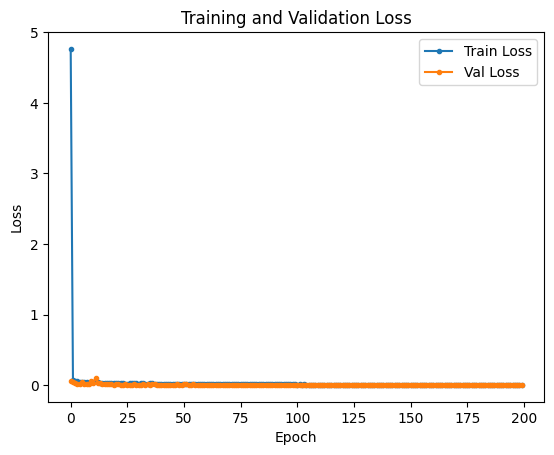

In [ ]:
x = list(range(NUM_EPOCHS))
plt.plot(x, train_loss_list, label="Train Loss", marker=".")
plt.plot(x, val_loss_list, label="Val Loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Step 4 - Save / load the model

After training, we need to save the models.

In [ ]:
# Save the trained model to disk
torch.save(vgg16.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to ./models/VGG16_full_test_size_0.2_epoch_200_batch_size_256_lr_1e-03_seed_42.pth


To read the saved data, we can run the following codes:

In [ ]:
# # Load the trained model weights
# vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
# vgg16.eval()
# print("Model loaded from", MODEL_PATH)

## Exceptional test

Let's see if the model works well.

Model loaded from ./models/VGG16_full_test_size_0.2_epoch_200_batch_size_256_lr_1e-03_seed_42.pth


      Real Labels  Predicted Labels      Diff      MAPE
0           1.746          1.784471  0.038471  0.977966
1           2.695          2.904059  0.209059  0.922427
2           1.816          2.034452  0.218452  0.879707
3           2.354          2.447012  0.093012  0.960488
4           3.901          3.719218 -0.181782  0.953401
...           ...               ...       ...       ...
1834        2.051          1.724297 -0.326703  0.840710
1835        1.757          1.688116 -0.068884  0.960794
1836        2.593          3.048476  0.455476  0.824344
1837        4.092          3.946128 -0.145872  0.964352
1838        2.040          1.696103 -0.343897  0.831423

[1839 rows x 4 columns]
MAPE: 0.9319866399090243


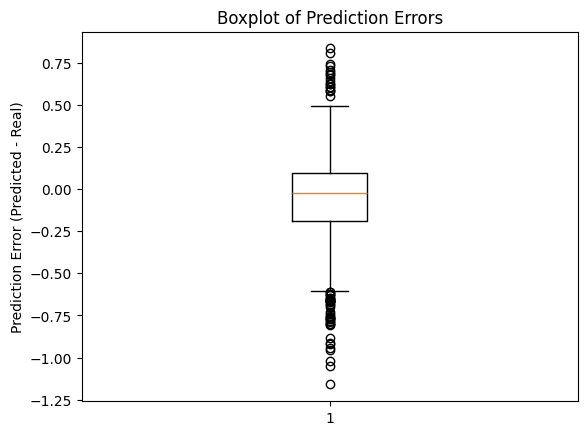

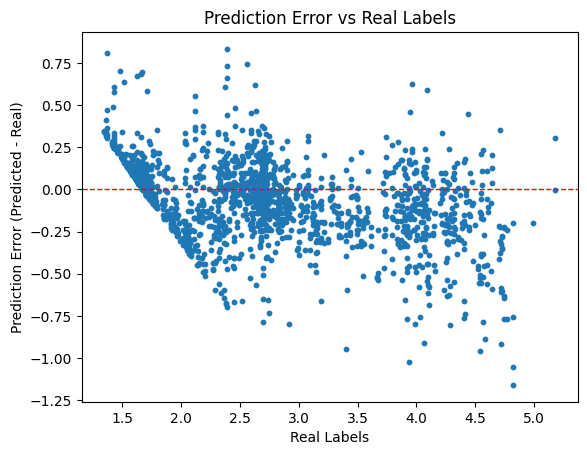

In [ ]:
# Load the trained model weights
vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
vgg16.eval()
print("Model loaded from", MODEL_PATH)

# Turn to `numpy.array`
labels_val_real = labels_val.numpy()
labels_val_predicted = []
for _images_val_tensor, _labels_val_tensor in val_loader:
    preds = vgg16(_images_val_tensor.to(device)).cpu().detach().numpy()
    labels_val_predicted.append(preds)
labels_val_predicted = np.concatenate(labels_val_predicted, axis=0)

# Unnormalize labels
labels_val_real = labels_val_real * (MAX_LABEL - MIN_LABEL) + MIN_LABEL
labels_val_predicted = labels_val_predicted * (MAX_LABEL - MIN_LABEL) + MIN_LABEL

# Turn to `pandas.Series`
labels_val_real = pd.Series(labels_val_real)
labels_val_predicted = pd.Series(labels_val_predicted.flatten())
labels_val_diff = labels_val_predicted - labels_val_real

# Make `pandas.DataFrame`
df = pd.DataFrame(
    {
        "Real Labels": labels_val_real,
        "Predicted Labels": labels_val_predicted,
        "Diff": labels_val_diff,
        "MAPE": 1 - np.abs(labels_val_diff) / labels_val_real
    }
)
df.to_csv(OUTPUT_PATH, index = False)
print(df)
print(f"MAPE: {df["MAPE"].mean()}")

# Boxplot of the differences
plt.boxplot(labels_val_diff)
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Boxplot of Prediction Errors")
plt.show()

# Plot the differences by the real labels.
plt.scatter(labels_val_real, labels_val_diff, s=10)
plt.xlabel("Real Labels")
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Prediction Error vs Real Labels")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()